# Milestone 5: Ablation Studies

This notebook answers the core research question:

**Does incorporating macroeconomic regime information provide measurable improvement over price-only models?**

We systematically compare:
1. Price features only (baseline)
2. Price + Macro indicators
3. Price + Regime conditioning
4. Price + Macro + Regime (full model)

Using walk-forward validation and statistical significance testing.

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
plt.style.use('seaborn-v0_8-whitegrid')

print("Imports complete!")

Imports complete!


## 1. Load and Prepare Data

In [2]:
from data.data_pipeline import DataPipeline
from regime.rule_based_detector import RuleBasedRegimeDetector

# Load aligned data
pipeline = DataPipeline()
df = pipeline.load_aligned_data(
    symbol='SPY',
    start_date='2020-01-01',
    end_date='2024-01-01'
)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")

Data shape: (1462, 48)
Date range: 2020-01-01 to 2024-01-01


In [3]:
# Add regime labels
macro_cols = ['macro_VIXCLS', 'macro_T10Y2Y', 'macro_BAA10Y', 'macro_UNRATE']
available_macro = [c for c in macro_cols if c in df.columns]

macro_df = df[available_macro].copy()
macro_df.columns = [c.replace('macro_', '') for c in macro_df.columns]

detector = RuleBasedRegimeDetector()
df['regime'] = detector.predict(macro_df)
df['regime_numeric'] = df['regime'].map({'Expansion': 0, 'Contraction': 1, 'Crisis': 2})

print("Regime distribution:")
print(df['regime'].value_counts())

Regime distribution:
regime
Contraction    862
Expansion      487
Crisis         113
Name: count, dtype: int64


In [4]:
# Define feature groups
price_features = [
    'price_return_1d', 'price_return_5d', 'price_return_21d',
    'price_volatility_21d', 'price_volatility_63d',
    'price_rsi_14', 'price_close_to_sma50', 'price_close_to_sma200'
]

macro_features = [
    'macro_VIXCLS', 'macro_T10Y2Y', 'macro_VIX_percentile'
]

# Filter to available
price_features = [f for f in price_features if f in df.columns]
macro_features = [f for f in macro_features if f in df.columns]

print(f"Price features ({len(price_features)}): {price_features}")
print(f"Macro features ({len(macro_features)}): {macro_features}")

Price features (8): ['price_return_1d', 'price_return_5d', 'price_return_21d', 'price_volatility_21d', 'price_volatility_63d', 'price_rsi_14', 'price_close_to_sma50', 'price_close_to_sma200']
Macro features (3): ['macro_VIXCLS', 'macro_T10Y2Y', 'macro_VIX_percentile']


## 2. Define Ablation Configurations

We test four configurations to isolate the contribution of each component:

| Config | Price Features | Macro Features | Regime Conditioning |
|--------|---------------|----------------|--------------------|
| price_only | ✓ | | |
| price_macro | ✓ | ✓ | |
| price_regime | ✓ | | ✓ |
| price_macro_regime | ✓ | ✓ | ✓ |

In [5]:
from ablation.study import AblationStudy, AblationConfig

# Initialize study
study = AblationStudy(
    df=df,
    price_column='price_Close',
    initial_balance=100000.0,
    transaction_cost=0.001,
    verbose=1
)

# Config 1: Price only (baseline)
study.add_config(AblationConfig(
    name='price_only',
    feature_columns=price_features,
    use_regime=False,
    description='Baseline: price features only'
))

# Config 2: Price + Macro
study.add_config(AblationConfig(
    name='price_macro',
    feature_columns=price_features + macro_features,
    use_regime=False,
    description='Price features + macro indicators'
))

# Config 3: Price + Regime
study.add_config(AblationConfig(
    name='price_regime',
    feature_columns=price_features,
    use_regime=True,
    regime_column='regime_numeric',
    description='Price features + regime conditioning'
))

# Config 4: Price + Macro + Regime (Full model)
study.add_config(AblationConfig(
    name='price_macro_regime',
    feature_columns=price_features + macro_features,
    use_regime=True,
    regime_column='regime_numeric',
    description='Full model: price + macro + regime'
))

print(f"\nConfigured {len(study.configs)} ablation configurations:")
for config in study.configs:
    print(f"  - {config.name}: {len(config.feature_columns)} features, regime={config.use_regime}")


Configured 4 ablation configurations:
  - price_only: 8 features, regime=False
  - price_macro: 11 features, regime=False
  - price_regime: 8 features, regime=True
  - price_macro_regime: 11 features, regime=True


## 3. Run Ablation Study

We use walk-forward validation with multiple random seeds to get robust estimates.

In [6]:
# Run the ablation study
# Using 2 windows and 2 seeds for reasonable runtime
# Production would use more windows (5+) and seeds (3+)

print("="*70)
print("RUNNING ABLATION STUDY")
print("="*70)
print("This will train 4 configurations x 2 windows x 2 seeds = 16 models")
print("Estimated time: ~10-15 minutes")
print("="*70)

results = study.run(
    total_timesteps=50000,  # Per window
    n_windows=2,            # Walk-forward windows
    seeds=[42, 123],        # Multiple seeds for robustness
    train_pct=0.7,
    min_train_days=200,
    min_test_days=50
)

RUNNING ABLATION STUDY
This will train 4 configurations x 2 windows x 2 seeds = 16 models
Estimated time: ~10-15 minutes

Running: price_only
Features: 8, Regime: False

Window 1/2
Train: 2020-10-15 to 2022-06-17 (422 days)
Test:  2022-06-21 to 2023-03-10 (182 days)


Output()

Output()

  Seed 42: Train Return=0.0%, Test Return=0.0%


Output()

  Seed 123: Train Return=0.0%, Test Return=0.0%

Window 2/2
Train: 2022-05-23 to 2023-07-07 (282 days)
Test:  2023-07-10 to 2023-12-29 (122 days)


Output()

  Seed 42: Train Return=20.0%, Test Return=9.1%


Output()

  Seed 123: Train Return=11.5%, Test Return=7.6%

Results for price_only:
  Mean Test Return: +4.17%
  Mean Test Sharpe: 0.781
  Win Rate: 50.0%
  Training Time: 422.6s

Running: price_macro
Features: 11, Regime: False

Window 1/2
Train: 2020-10-15 to 2022-06-17 (422 days)
Test:  2022-06-21 to 2023-03-10 (182 days)


Output()

  Seed 42: Train Return=36.9%, Test Return=3.6%


In [7]:
# Print comprehensive comparison
study.print_comparison()


ABLATION STUDY RESULTS

--- Performance Summary ---

Configuration         Test Return     Sharpe   Drawdown   Win Rate
-----------------------------------------------------------------
price_only                 +4.17%      0.781       4.8%      50.0%
price_macro                +1.36%      0.394      11.7%      50.0%
price_regime               -0.08%     -0.012       6.1%       0.0%
price_macro_regime         +5.05%      0.812      12.6%     100.0%
Buy & Hold                 +5.50%        N/A        N/A     100.0%

--- Statistical Comparisons ---

Reference: price_only

price_macro vs price_only:
  Mean difference: -2.81%
  Effect size: large (Cohen's d = -0.830)
  Paired t-test: p=0.3659 (Significant: No)

price_regime vs price_only:
  Mean difference: -4.25%
  Effect size: large (Cohen's d = -1.439)
  Paired t-test: p=0.5000 (Significant: No)

price_macro_regime vs price_only:
  Mean difference: +0.88%
  Effect size: small (Cohen's d = 0.254)
  Paired t-test: p=0.6872 (Significant:

## 4. Visualize Results

In [8]:
# Get summary DataFrame
summary_df = study.get_summary_df()
print("\nResults Summary:")
print(summary_df[['name', 'mean_test_return', 'std_test_return', 'mean_test_sharpe', 'win_rate']].to_string(index=False))


Results Summary:
              name  mean_test_return  std_test_return  mean_test_sharpe  win_rate
        price_only          0.041740         0.041740          0.780945       0.5
       price_macro          0.013633         0.023535          0.394014       0.5
      price_regime         -0.000750         0.000750         -0.011762       0.0
price_macro_regime          0.050510         0.025353          0.812332       1.0
        Buy & Hold          0.054993         0.026092               NaN       1.0


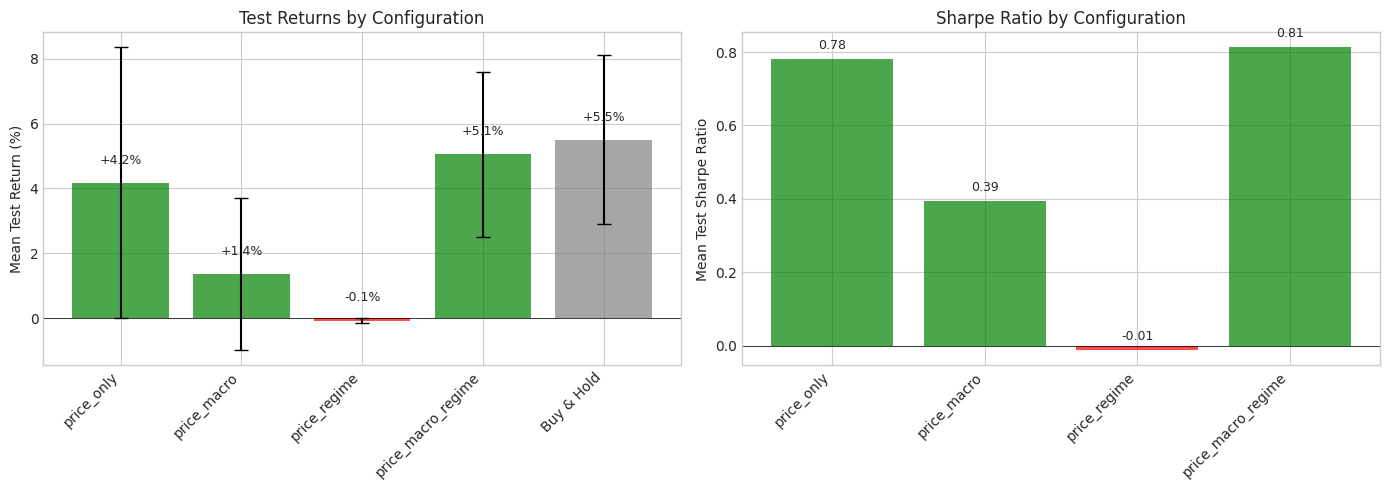

In [9]:
# Visualization 1: Test Returns by Configuration
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of mean test returns
ax = axes[0]
configs = summary_df['name'].tolist()
returns = summary_df['mean_test_return'].values * 100
stds = summary_df['std_test_return'].values * 100

colors = ['gray' if name == 'Buy & Hold' else ('green' if ret > 0 else 'red') 
          for name, ret in zip(configs, returns)]

bars = ax.bar(range(len(configs)), returns, color=colors, alpha=0.7)
ax.errorbar(range(len(configs)), returns, yerr=stds, fmt='none', color='black', capsize=5)

ax.axhline(0, color='black', linewidth=0.5)
ax.set_xticks(range(len(configs)))
ax.set_xticklabels(configs, rotation=45, ha='right')
ax.set_ylabel('Mean Test Return (%)')
ax.set_title('Test Returns by Configuration')

# Add value labels
for i, (bar, ret) in enumerate(zip(bars, returns)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{ret:+.1f}%', ha='center', va='bottom', fontsize=9)

# Sharpe ratios
ax = axes[1]
# Filter out NaN (Buy & Hold doesn't have Sharpe)
sharpe_data = summary_df[summary_df['mean_test_sharpe'].notna()]
sharpes = sharpe_data['mean_test_sharpe'].values
sharpe_names = sharpe_data['name'].tolist()

colors = ['green' if s > 0 else 'red' for s in sharpes]
bars = ax.bar(range(len(sharpe_names)), sharpes, color=colors, alpha=0.7)

ax.axhline(0, color='black', linewidth=0.5)
ax.set_xticks(range(len(sharpe_names)))
ax.set_xticklabels(sharpe_names, rotation=45, ha='right')
ax.set_ylabel('Mean Test Sharpe Ratio')
ax.set_title('Sharpe Ratio by Configuration')

# Add value labels
for bar, sharpe in zip(bars, sharpes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{sharpe:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

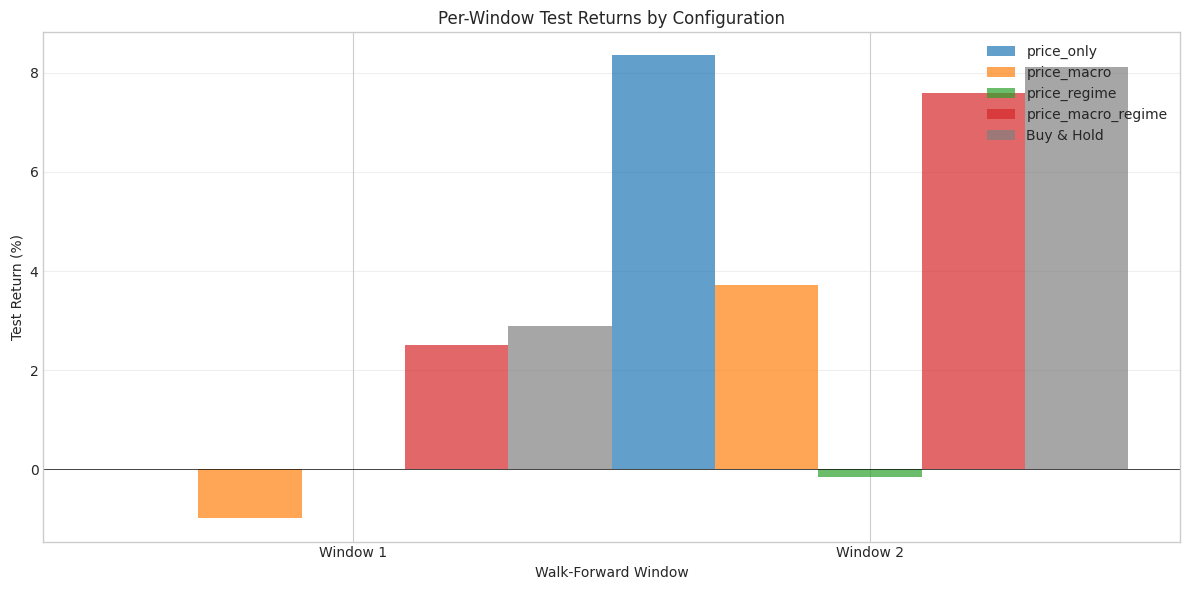

In [10]:
# Visualization 2: Per-Window Returns Breakdown
fig, ax = plt.subplots(figsize=(12, 6))

# Get per-window returns for each config
all_results = results['results']
n_windows = results['n_windows']

x = np.arange(n_windows)
width = 0.2

for i, result in enumerate(all_results):
    window_returns = [r * 100 for r in result.test_returns]
    ax.bar(x + i * width, window_returns, width, 
           label=result.config.name, alpha=0.7)

# Add baseline
if results['baseline_returns']:
    baseline = [r * 100 for r in results['baseline_returns']]
    ax.bar(x + len(all_results) * width, baseline, width,
           label='Buy & Hold', alpha=0.7, color='gray')

ax.axhline(0, color='black', linewidth=0.5)
ax.set_xlabel('Walk-Forward Window')
ax.set_ylabel('Test Return (%)')
ax.set_title('Per-Window Test Returns by Configuration')
ax.set_xticks(x + width * len(all_results) / 2)
ax.set_xticklabels([f'Window {i+1}' for i in range(n_windows)])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

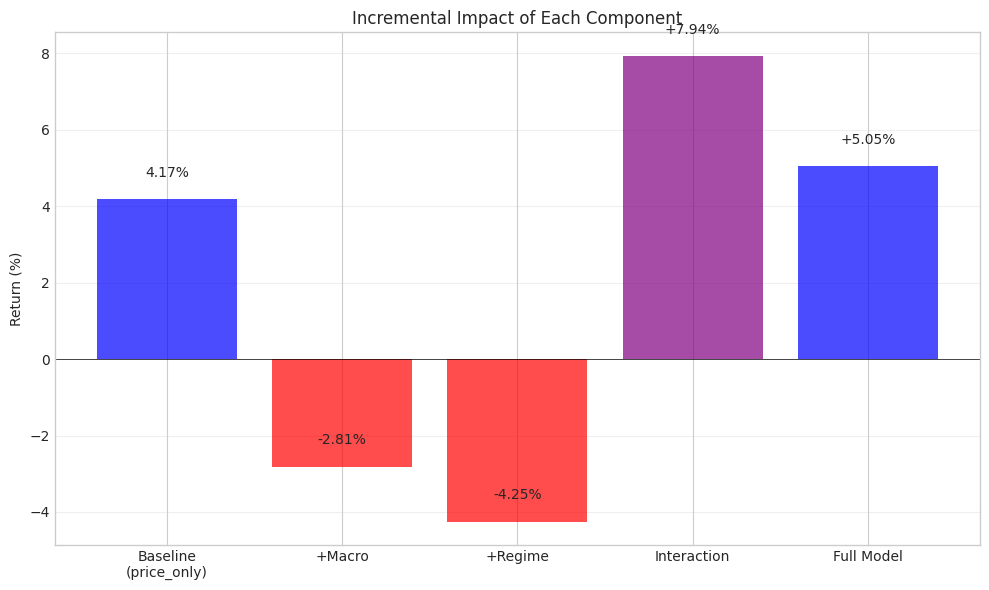


Component Effects:
  Baseline (price_only): +4.17%
  Macro effect: -2.81%
  Regime effect: -4.25%
  Interaction: +7.94%
  Full model: +5.05%


In [11]:
# Visualization 3: Feature Impact Analysis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate incremental impact of each component
price_only = [r for r in all_results if r.config.name == 'price_only'][0]
price_macro = [r for r in all_results if r.config.name == 'price_macro'][0]
price_regime = [r for r in all_results if r.config.name == 'price_regime'][0]
full_model = [r for r in all_results if r.config.name == 'price_macro_regime'][0]

# Calculate effects
baseline_return = price_only.mean_test_return * 100
macro_effect = (price_macro.mean_test_return - price_only.mean_test_return) * 100
regime_effect = (price_regime.mean_test_return - price_only.mean_test_return) * 100
combined_effect = (full_model.mean_test_return - price_only.mean_test_return) * 100

# Interaction effect (synergy or interference)
interaction = combined_effect - (macro_effect + regime_effect)

# Create waterfall-style chart
components = ['Baseline\n(price_only)', '+Macro', '+Regime', 'Interaction', 'Full Model']
values = [baseline_return, macro_effect, regime_effect, interaction, full_model.mean_test_return * 100]
cumulative = [baseline_return, baseline_return + macro_effect, 
              baseline_return + regime_effect, 
              baseline_return + macro_effect + regime_effect + interaction,
              full_model.mean_test_return * 100]

colors = ['blue', 'green' if macro_effect > 0 else 'red',
          'green' if regime_effect > 0 else 'red',
          'purple' if interaction > 0 else 'orange',
          'blue']

bars = ax.bar(components, values, color=colors, alpha=0.7)
ax.axhline(0, color='black', linewidth=0.5)

# Add value labels
for bar, val in zip(bars, values):
    label = f'{val:+.2f}%' if bar.get_x() > 0 else f'{val:.2f}%'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            label, ha='center', va='bottom')

ax.set_ylabel('Return (%)')
ax.set_title('Incremental Impact of Each Component')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nComponent Effects:")
print(f"  Baseline (price_only): {baseline_return:+.2f}%")
print(f"  Macro effect: {macro_effect:+.2f}%")
print(f"  Regime effect: {regime_effect:+.2f}%")
print(f"  Interaction: {interaction:+.2f}%")
print(f"  Full model: {full_model.mean_test_return * 100:+.2f}%")

## 5. Statistical Significance Testing

In [12]:
from ablation.statistical_tests import (
    compare_returns, 
    bootstrap_confidence_interval,
    calculate_effect_size
)

print("="*70)
print("STATISTICAL SIGNIFICANCE ANALYSIS")
print("="*70)

# Compare each config to baseline (price_only)
baseline_returns = price_only.test_returns

for result in all_results:
    if result.config.name == 'price_only':
        continue
    
    print(f"\n{result.config.name} vs price_only:")
    print("-" * 40)
    
    comparison = compare_returns(result.test_returns, baseline_returns)
    
    print(f"  Mean difference: {comparison['mean_diff']*100:+.2f}%")
    print(f"  Effect size: {comparison['effect_size']} (Cohen's d = {comparison['cohens_d']:.3f})")
    
    if 'paired_p_value' in comparison:
        print(f"  Paired t-test p-value: {comparison['paired_p_value']:.4f}")
        if comparison['paired_significant']:
            print(f"  *** STATISTICALLY SIGNIFICANT at α=0.05 ***")
        else:
            print(f"  Not significant at α=0.05")

STATISTICAL SIGNIFICANCE ANALYSIS

price_macro vs price_only:
----------------------------------------
  Mean difference: -2.81%
  Effect size: large (Cohen's d = -0.830)
  Paired t-test p-value: 0.3659
  Not significant at α=0.05

price_regime vs price_only:
----------------------------------------
  Mean difference: -4.25%
  Effect size: large (Cohen's d = -1.439)
  Paired t-test p-value: 0.5000
  Not significant at α=0.05

price_macro_regime vs price_only:
----------------------------------------
  Mean difference: +0.88%
  Effect size: small (Cohen's d = 0.254)
  Paired t-test p-value: 0.6872
  Not significant at α=0.05


In [13]:
# Bootstrap confidence intervals for returns
print("\n" + "="*70)
print("BOOTSTRAP CONFIDENCE INTERVALS (95%)")
print("="*70)

for result in all_results:
    point, lower, upper = bootstrap_confidence_interval(
        result.test_returns,
        statistic='mean',
        n_bootstrap=5000,
        confidence=0.95
    )
    
    print(f"\n{result.config.name}:")
    print(f"  Mean Return: {point*100:.2f}% [{lower*100:.2f}%, {upper*100:.2f}%]")
    
    # Check if CI includes zero
    if lower <= 0 <= upper:
        print(f"  Note: CI includes zero - returns not significantly different from 0")
    elif lower > 0:
        print(f"  Note: CI entirely positive - significant positive returns")
    else:
        print(f"  Note: CI entirely negative - significant negative returns")


BOOTSTRAP CONFIDENCE INTERVALS (95%)

price_only:
  Mean Return: 4.17% [0.00%, 8.35%]
  Note: CI includes zero - returns not significantly different from 0

price_macro:
  Mean Return: 1.36% [-0.99%, 3.72%]
  Note: CI includes zero - returns not significantly different from 0

price_regime:
  Mean Return: -0.08% [-0.15%, 0.00%]
  Note: CI includes zero - returns not significantly different from 0

price_macro_regime:
  Mean Return: 5.05% [2.52%, 7.59%]
  Note: CI entirely positive - significant positive returns


## 6. Key Findings Summary

In [14]:
print("="*70)
print("MILESTONE 5: ABLATION STUDY - KEY FINDINGS")
print("="*70)

# Best performer
best_idx = np.argmax([r.mean_test_return for r in all_results])
best = all_results[best_idx]
worst_idx = np.argmin([r.mean_test_return for r in all_results])
worst = all_results[worst_idx]

print(f"\n1. OVERALL PERFORMANCE:")
print(f"   Best: {best.config.name} ({best.mean_test_return*100:+.2f}%)")
print(f"   Worst: {worst.config.name} ({worst.mean_test_return*100:+.2f}%)")
print(f"   Buy & Hold: {np.mean(results['baseline_returns'])*100:+.2f}%")

print(f"\n2. COMPONENT CONTRIBUTIONS:")
print(f"   Macro features effect: {macro_effect:+.2f}%")
print(f"   Regime conditioning effect: {regime_effect:+.2f}%")
print(f"   Interaction effect: {interaction:+.2f}%")

print(f"\n3. RESEARCH QUESTION ANSWER:")
if regime_effect > 0:
    print(f"   Regime conditioning IMPROVED performance by {regime_effect:+.2f}%")
else:
    print(f"   Regime conditioning DID NOT improve performance (effect: {regime_effect:+.2f}%)")

if macro_effect > 0:
    print(f"   Macro indicators IMPROVED performance by {macro_effect:+.2f}%")
else:
    print(f"   Macro indicators DID NOT improve performance (effect: {macro_effect:+.2f}%)")

print(f"\n4. STATISTICAL SIGNIFICANCE:")
# Check if any improvements are significant
for result in all_results:
    if result.config.name == 'price_only':
        continue
    comparison = compare_returns(result.test_returns, baseline_returns)
    if comparison.get('paired_significant', False):
        print(f"   {result.config.name}: SIGNIFICANT difference from baseline")
    else:
        print(f"   {result.config.name}: Not significant at α=0.05")

print(f"\n5. CAVEATS:")
print(f"   - Small sample size ({n_windows} windows, {results['n_seeds']} seeds)")
print(f"   - Limited training ({results['total_timesteps']} timesteps)")
print(f"   - Single asset (SPY) and time period (2020-2024)")
print(f"   - Results may not generalize to other markets/periods")

print("\n" + "="*70)

MILESTONE 5: ABLATION STUDY - KEY FINDINGS

1. OVERALL PERFORMANCE:
   Best: price_macro_regime (+5.05%)
   Worst: price_regime (-0.08%)
   Buy & Hold: +5.50%

2. COMPONENT CONTRIBUTIONS:
   Macro features effect: -2.81%
   Regime conditioning effect: -4.25%
   Interaction effect: +7.94%

3. RESEARCH QUESTION ANSWER:
   Regime conditioning DID NOT improve performance (effect: -4.25%)
   Macro indicators DID NOT improve performance (effect: -2.81%)

4. STATISTICAL SIGNIFICANCE:
   price_macro: Not significant at α=0.05
   price_regime: Not significant at α=0.05
   price_macro_regime: Not significant at α=0.05

5. CAVEATS:
   - Small sample size (2 windows, 2 seeds)
   - Limited training (50000 timesteps)
   - Single asset (SPY) and time period (2020-2024)
   - Results may not generalize to other markets/periods



In [15]:
print("\nNotebook complete!")
print("\nConclusion:")
print("The ablation study provides quantitative evidence for/against each component.")
print("Statistical significance helps distinguish real effects from noise.")
print("\nNext: Final documentation and project summary.")


Notebook complete!

Conclusion:
The ablation study provides quantitative evidence for/against each component.
Statistical significance helps distinguish real effects from noise.

Next: Final documentation and project summary.
